In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
from collections import Counter
import pandas as pd
import random
import matplotlib.pyplot as plt
import itertools

# Load Data

## .tsv to list

In [101]:
def load_data(filename):
    file = pd.read_csv(filename, sep='\t')
    data = [[file.iloc[i,0],file.iloc[i,1]] for i in range(len(file.index))]
    file['label'] = file['label'].replace(['entailment', 'contradiction', 'neutral'], [0,1,2])
    labels = file['label']
#     file['genre'] = file['genre'].replace(['telephone', 'fiction', 'slate', 'government', 'travel'], [0,1,2,3,4])
#     genres = file['genre']
    return data, labels

In [102]:
train_data, train_targets = load_data('snli_train.tsv')
val_data, val_targets = load_data('snli_val.tsv')
file = pd.read_csv('snli_train.tsv', sep='\t')
file = file[:10000]
# file['label']= file['label'].replace(['entailment', 'contradiction', 'neutral'], [0,1,2])
# file.iloc[5,0]

In [78]:
train_data = train_data[:30000]
train_targets = train_targets[:30000]

In [103]:
len(train_data)


100000

## Tokenization

In [104]:
train_data_tokens = [[train_data[i][j].split() for j in range(2)] for i in range(len(train_data))]

In [105]:
val_data_tokens = [[val_data[i][j].split() for j in range(2)] for i in range(len(val_data))]

In [106]:
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))

Train dataset size is 100000
Val dataset size is 1000


In [107]:
train_data_tokens[0]

[['A',
  'young',
  'girl',
  'in',
  'a',
  'pink',
  'shirt',
  'sitting',
  'on',
  'a',
  'dock',
  'viewing',
  'a',
  'body',
  'of',
  'water',
  '.'],
 ['A',
  'young',
  'girl',
  'watching',
  'the',
  'sunset',
  'over',
  'the',
  'water',
  '.']]

## Fasttext Word Embedding

In [108]:
with open('wiki-news-300d-1M.vec') as f:
    lines = []
    for i in range(50001):
        line = f.readline()
        v = line.split()
        for j in range(1,len(v)):
            v[j] = float(v[j])
        lines.append(v)
        
lines.remove(lines[0])  

In [109]:
word_dict = {}
word_dict['PAD'] = 0
word_dict['UNK'] = 1

embed = [[0 for i in range(300)],[0 for i in range(300)]]

for i in range(len(lines)):
    word_dict['PAD'] = 0
    word_dict['UNK'] = 1
    word_dict[lines[i][0]] = i+2
    embed.append(lines[i][1:])
    
embedding_matrix = np.matrix(embed)

id2token = []
for word in word_dict.keys():
    id2token.append(word)
token2id = word_dict

In [110]:
print(len(id2token))

50002


In [111]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 20436 ; token sufferers
Token sufferers; token id 20436


In [112]:
id2token[106]

'A'

In [113]:
UNK_IDX = 1
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        sublist = []
        for i in range(2):
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens[i]]
            sublist.append(index_list)
        indices_data.append(sublist)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)

In [114]:
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))

Train dataset size is 100000
Val dataset size is 1000


In [115]:
train_data_indices[0]

[[106,
  802,
  1830,
  8,
  9,
  6265,
  7167,
  4388,
  17,
  9,
  12229,
  5335,
  9,
  563,
  6,
  358,
  4],
 [106, 802, 1830, 2255, 3, 13985, 94, 3, 358, 4]]

## Pytorch DataLoader

In [116]:
MAX_SENTENCE_LENGTH = 25
class SNLIDataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_1 = self.data_list[key][0][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list[key][1][:MAX_SENTENCE_LENGTH]
        token_idx = [token_idx_1, token_idx_2]
        label = self.target_list[key]
        return [token_idx, [len(token_idx_1), len(token_idx_2)], label]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0][0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][0])), 
                                mode="constant", constant_values=0)
        padded_vec_2 = np.pad(np.array(datum[0][1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][1])), 
                                mode="constant", constant_values=0)
#         sublist = ' '.join(padded_vec_2)
#         data_list.append(padded_vec_1)
#         data_list.append(padded_vec_2)
        data_list.append(list(padded_vec_1) + list(padded_vec_2))
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [117]:
BATCH_SIZE = 40
train_dataset = SNLIDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [118]:
for i, (data, lengths, labels) in enumerate(train_loader):
    print (len(data))
    print (lengths)
    break
print (data[0])

40
tensor([[17, 14],
        [ 6, 10],
        [14, 11],
        [16,  5],
        [ 9,  8],
        [10, 10],
        [20, 11],
        [13, 11],
        [10, 10],
        [ 9,  6],
        [10,  7],
        [25,  9],
        [ 8,  7],
        [ 8,  8],
        [15, 10],
        [13, 10],
        [25,  4],
        [11, 13],
        [ 9,  5],
        [12,  8],
        [11, 13],
        [14,  5],
        [ 7,  7],
        [10,  6],
        [11, 10],
        [22,  8],
        [17, 15],
        [19,  9],
        [12,  6],
        [11, 12],
        [12, 11],
        [11,  5],
        [12,  7],
        [19, 11],
        [ 9,  5],
        [ 9,  9],
        [13, 10],
        [ 9,  4],
        [10,  6],
        [20,  6]])
tensor([  106,   347,     8,     9,  7810,  7167,     5,   884, 11907,    15,
           48,     7,  4398,     9,  2418,  2328,     4,     0,     0,     0,
            0,     0,     0,     0,     0,   106,   347,    15,     8,     3,
          872,   978,  6824,     9,  2328,

In [119]:
weight = torch.FloatTensor(embed)

class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
#         self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding = nn.Embedding.from_pretrained(weight)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=MAX_SENTENCE_LENGTH)
        
        self.linear1 = nn.Linear(hidden_size*2, 128)
        self.dropout = nn.Dropout(p=0.25)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(128, num_classes)

    def forward(self, x, lengths):
        batch_size, seq_len = x.size()

        embed = self.embedding(x)
        embed_1 = embed[:, :MAX_SENTENCE_LENGTH, :]
        embed_2 = embed[:, MAX_SENTENCE_LENGTH:, :]

        hidden_1 = self.conv1(embed_1.transpose(1,2)).transpose(1, 2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, MAX_SENTENCE_LENGTH, hidden_1.size(-1))
        
#         print(hidden_1.size())
        hidden_1 = self.conv2(hidden_1.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, MAX_SENTENCE_LENGTH, hidden_1.size(-1))
        
        hidden_2 = self.conv3(embed_2.transpose(1,2)).transpose(1, 2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, MAX_SENTENCE_LENGTH, hidden_2.size(-1))

        hidden_2 = self.conv4(hidden_2.transpose(1,2)).transpose(1,2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, MAX_SENTENCE_LENGTH, hidden_2.size(-1))

        # max pool
        hidden_1 = self.maxpool(hidden_1.transpose(1, 2)).transpose(1, 2)
        hidden_1 = torch.squeeze(hidden_1, dim=1)
        hidden_2 = self.maxpool(hidden_2.transpose(1, 2)).transpose(1, 2)
        hidden_2 = torch.squeeze(hidden_2, dim=1)
        
        hidden = torch.cat((hidden_1, hidden_2), dim=1)
#         print(hidden.size())
        
        hidden = self.linear1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.activation(hidden)
        logits = self.linear2(hidden)
        return logits

In [120]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(emb_size=300, hidden_size=500, num_layers=2, num_classes=3, vocab_size=len(id2token)) # num_layers

learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

loss_l = []
acc_l = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data, lengths)
        loss = criterion(outputs, labels)
        if i % 64 == 0:
            loss_l.append(loss.item())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            acc_l.append(val_acc)

Epoch: [1/10], Step: [101/2500], Validation Acc: 45.1
Epoch: [1/10], Step: [201/2500], Validation Acc: 54.8
Epoch: [1/10], Step: [301/2500], Validation Acc: 55.3
Epoch: [1/10], Step: [401/2500], Validation Acc: 55.3
Epoch: [1/10], Step: [501/2500], Validation Acc: 58.0
Epoch: [1/10], Step: [601/2500], Validation Acc: 59.3
Epoch: [1/10], Step: [701/2500], Validation Acc: 59.9
Epoch: [1/10], Step: [801/2500], Validation Acc: 58.9
Epoch: [1/10], Step: [901/2500], Validation Acc: 61.7
Epoch: [1/10], Step: [1001/2500], Validation Acc: 60.1
Epoch: [1/10], Step: [1101/2500], Validation Acc: 62.2
Epoch: [1/10], Step: [1201/2500], Validation Acc: 62.1
Epoch: [1/10], Step: [1301/2500], Validation Acc: 60.8
Epoch: [1/10], Step: [1401/2500], Validation Acc: 61.9
Epoch: [1/10], Step: [1501/2500], Validation Acc: 61.7
Epoch: [1/10], Step: [1601/2500], Validation Acc: 64.9
Epoch: [1/10], Step: [1701/2500], Validation Acc: 63.1
Epoch: [1/10], Step: [1801/2500], Validation Acc: 61.9
Epoch: [1/10], Step

Epoch: [7/10], Step: [801/2500], Validation Acc: 65.9
Epoch: [7/10], Step: [901/2500], Validation Acc: 65.9
Epoch: [7/10], Step: [1001/2500], Validation Acc: 65.5
Epoch: [7/10], Step: [1101/2500], Validation Acc: 64.5
Epoch: [7/10], Step: [1201/2500], Validation Acc: 65.8
Epoch: [7/10], Step: [1301/2500], Validation Acc: 65.2
Epoch: [7/10], Step: [1401/2500], Validation Acc: 65.3
Epoch: [7/10], Step: [1501/2500], Validation Acc: 66.4
Epoch: [7/10], Step: [1601/2500], Validation Acc: 65.5
Epoch: [7/10], Step: [1701/2500], Validation Acc: 64.4
Epoch: [7/10], Step: [1801/2500], Validation Acc: 66.3
Epoch: [7/10], Step: [1901/2500], Validation Acc: 66.0
Epoch: [7/10], Step: [2001/2500], Validation Acc: 66.1
Epoch: [7/10], Step: [2101/2500], Validation Acc: 66.0
Epoch: [7/10], Step: [2201/2500], Validation Acc: 67.9
Epoch: [7/10], Step: [2301/2500], Validation Acc: 67.4
Epoch: [7/10], Step: [2401/2500], Validation Acc: 65.4
Epoch: [8/10], Step: [101/2500], Validation Acc: 67.6
Epoch: [8/10]

KeyboardInterrupt: 

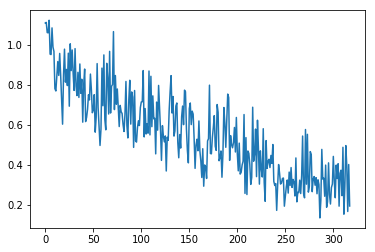

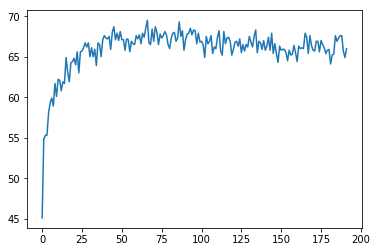

In [123]:
plt.plot(loss_l)
plt.show()
plt.plot(acc_l)
plt.show()